# Measure GRACE performance on identified objects:

All metrics here are **exact**, i.e measure similarity between two graphs formed of identical node count which have the same positions. The only thing that differs between the graphs is the edges and object membership / individual identities. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from grace.io.image_dataset import ImageGraphDataset
from grace.models.optimiser import optimise_graph
from grace.simulator.simulate_graph import random_graph

from grace.evaluation.metrics_objects import (
    ExactMetricsComputer,
    ApproxMetricsComputer,
)

from grace.evaluation.process import (
    generate_ground_truth_graph,
    update_graph_with_dummy_predictions,
    add_and_remove_random_edges,
)
from grace.visualisation.plotting import (
    plot_simple_graph,
    plot_connected_components,
)
from grace.visualisation.annotation import (
    draw_annotation_mask_from_ground_truth_graph,
)

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# *EXACT* metrics on graph:

### Generate a random graph, update dummy labels & generate GT graph:

In [3]:
MOTIFS = ["line", "curve"]
N_MOTIFS = 2
DENSITY = 0.01

def generate_random_optimised_and_GT_graphs():
    G = random_graph(
        n_motifs=N_MOTIFS, 
        density=DENSITY, 
        motifs=MOTIFS
    )
    node_conf, edge_conf = 0.5, 0.1
    update_graph_with_dummy_predictions(
        G, 
        node_uncertainty=node_conf, 
        edge_uncertainty=edge_conf
    )
    true_graph = generate_ground_truth_graph(G)
    pred_graph = optimise_graph(G)

    return G, pred_graph, true_graph

### Keep making graphs until the prediction and GT come out different:

In [4]:
synthesize = True
counter = 0

while synthesize:
    counter += 1
    print (f"Synthesizing imperfectly optimised graph: iter = {counter}")

    G, pred_graph, true_graph = generate_random_optimised_and_GT_graphs()
    node_con = pred_graph.number_of_nodes() == true_graph.number_of_nodes()
    edge_con = pred_graph.number_of_edges() != true_graph.number_of_edges()
    
    if node_con and edge_con:
        synthesize = False


Synthesizing imperfectly optimised graph: iter = 1
Synthesizing imperfectly optimised graph: iter = 2


### Visualise the resulting graphs:

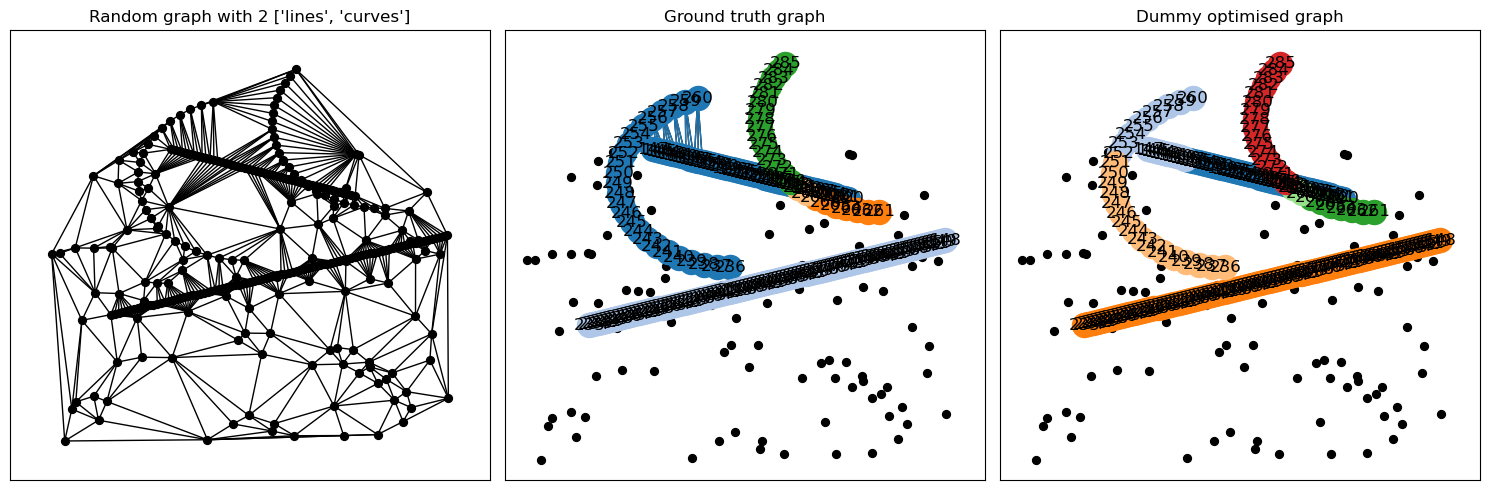

In [5]:
shape = 5
_, axes = plt.subplots(1, 3, figsize=(shape*3, shape*1))

plot_simple_graph(G, title=f"Random graph with {N_MOTIFS} {MOTIFS}", ax=axes[0])
plot_connected_components(true_graph, title=f"Ground truth graph", ax=axes[1])
plot_connected_components(pred_graph, title=f"Dummy optimised graph", ax=axes[2])

plt.tight_layout()
plt.show()

## Evaluate the *exact* metrics on graphs:

In [6]:
EMC = ExactMetricsComputer(G=G, pred_optimised_graph=pred_graph, true_annotated_graph=true_graph)
results = EMC.metrics()
results

{'Accuracy (nodes)': 1.0,
 'Precision (nodes)': 1.0,
 'Recall (nodes)': 1.0,
 'F1-Score (nodes)': 1.0,
 'Accuracy (edges)': 0.9726516052318668,
 'Precision (edges)': 0.8983050847457628,
 'Recall (edges)': 0.9695121951219512,
 'F1-Score (edges)': 0.9325513196480938,
 'Semantic IoU': 1.0,
 'Instance IoU [mean]': 0.7142857142857143,
 'Instance IoU [std]': 0.3412839547433348,
 'Instance IoU [list]': [0.5205479452054794,
  0.2602739726027397,
  1.0,
  0.2191780821917808,
  1.0,
  1.0,
  1.0]}

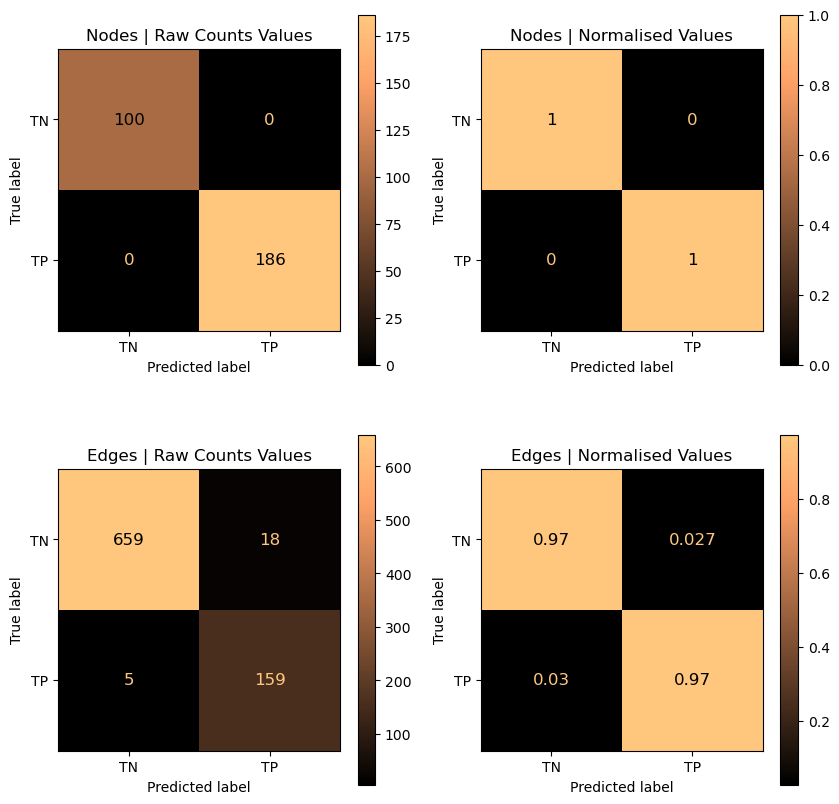

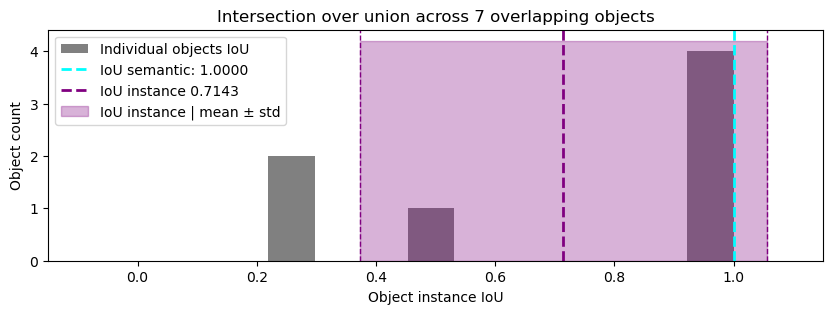

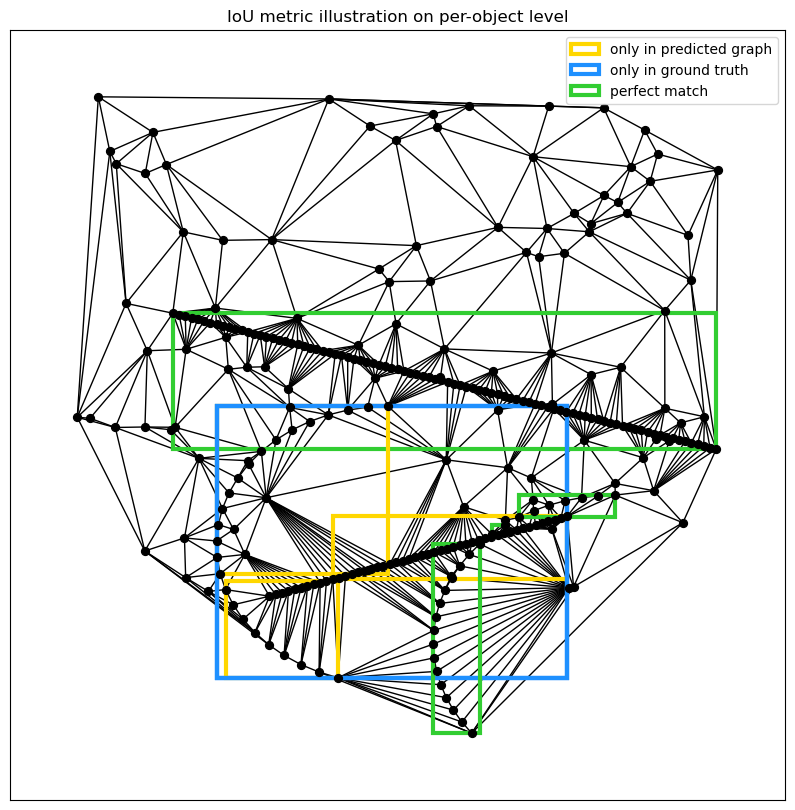

In [7]:
EMC.visualise()

# *Approx* metrics on annotation masks:

### Open an annotated image & visualise the annotation:

In [8]:
grace_path = "/Users/kulicna/Desktop/dataset/shape_stars/infer"
dataset = ImageGraphDataset(
    image_dir=grace_path, 
    grace_dir=grace_path, 
    keep_node_unknown_labels=False,
    keep_edge_unknown_labels=False,
    verbose=True
)
image, graph_data = dataset[0]


09/19/2023 12:03:57 PM MRC_Synthetic_File_006
09/19/2023 12:03:57 PM Nodes count | [56, 96, 37] x | [29.63, 50.79, 19.58] %
09/19/2023 12:03:57 PM Edges count | [246, 111, 195] x | [44.57, 20.11, 35.33] %
09/19/2023 12:03:57 PM Relabelled 'Annotation.UNKNOWN'
09/19/2023 12:03:57 PM Nodes count | [93, 96, 0] x | [49.21, 50.79, 0.0] %
09/19/2023 12:03:57 PM Edges count | [441, 111, 0] x | [79.89, 20.11, 0.0] %


### Prepare the GT graph & both hand- and auto-annotated masks:

To demonstrate that the metrics evaluation is really working, add & remove a few random edges just to mess up with the graph:

In [9]:
G = graph_data["graph"]
update_graph_with_dummy_predictions(G)

true_graph = generate_ground_truth_graph(G)
true_anno = graph_data["annotation"]

pred_graph = add_and_remove_random_edges(true_graph, G, 3, 5)
pred_anno = draw_annotation_mask_from_ground_truth_graph(
    pred_graph, 
    shape=image.shape, 
    brush_size=75
)

### Visualise together with the original image:

In [10]:
def plot_image_with_masks(image_dict: dict[str, np.ndarray], figsize : tuple[int, int] = (15, 5)):
    _, axes = plt.subplots(1, len(image_dict), figsize=figsize)

    for i, (title, image) in enumerate(image_dict.items()):
        im = axes[i].imshow(image, cmap="binary_r")
        axes[i].set_title(title)
        plt.colorbar(im, ax=axes[i], fraction=0.045)
        
    plt.tight_layout()
    plt.show()


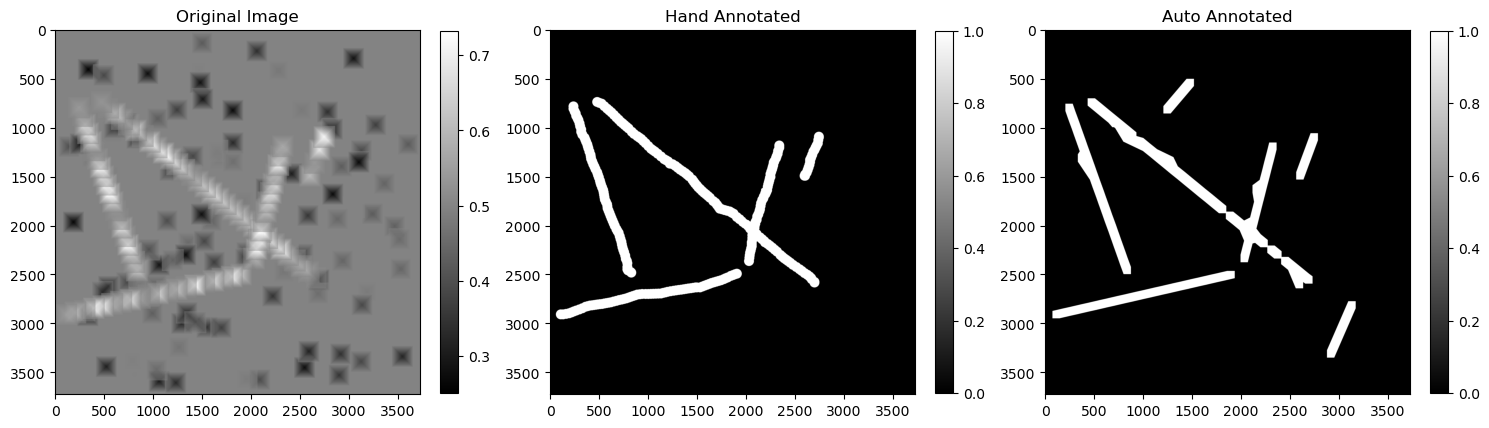

In [11]:
image_dict = {
    "Original Image" : image,
    "Hand Annotated" : true_anno,
    "Auto Annotated" : pred_anno,
}
plot_image_with_masks(image_dict)

## Evaluate the *approx* metrics on masks:

In [12]:
AMC = ApproxMetricsComputer(G, pred_anno, true_anno)
results = AMC.metrics()
results

{'Pixel Accuracy': 0.9740710674568883,
 'Semantic IoU': 0.6654687235440014,
 'Instance IoU [mean]': 0.5092659838124672,
 'Instance IoU [std]': 0.36476946538368515,
 'Instance IoU [list]': [0.0,
  0.7319959390862945,
  0.7729847743261177,
  0.8725813882063882,
  0.678033801256003,
  0.0]}

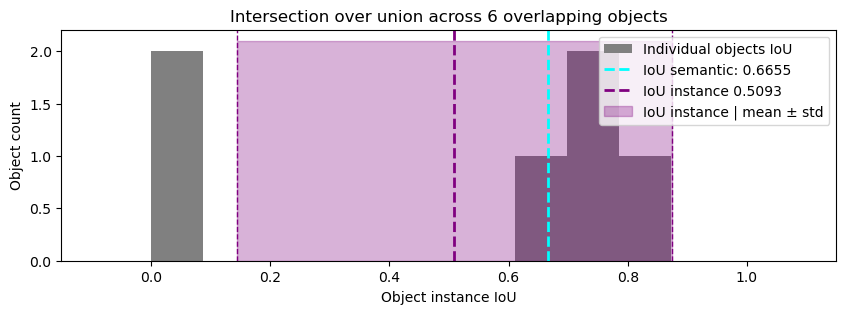

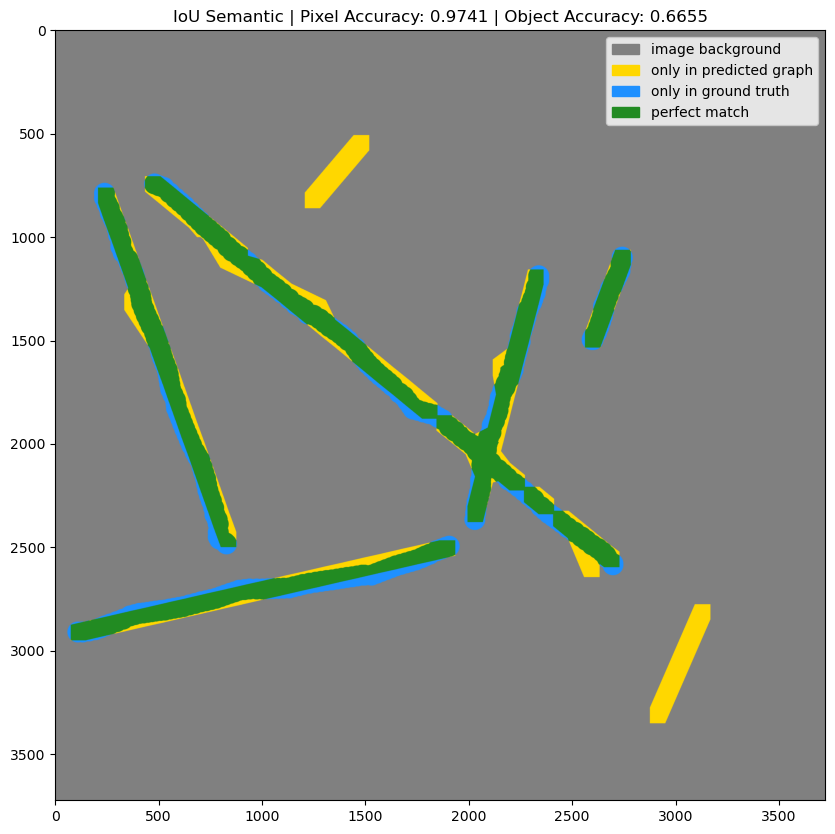

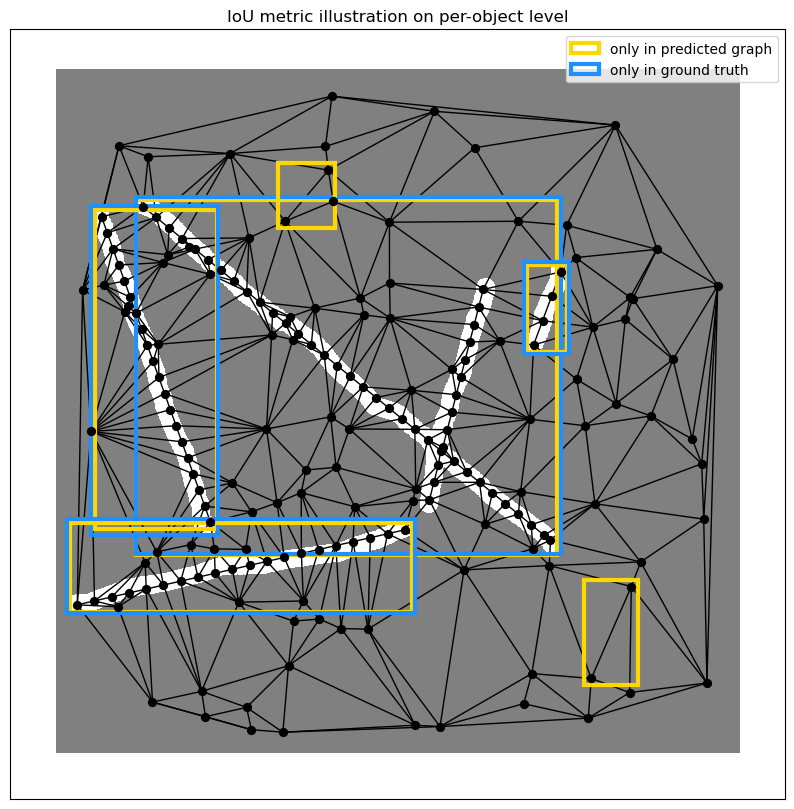

In [13]:
AMC.visualise()

### Done!